# Example of confidence interval computation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import FrequentistCalculator
from hepstats.hypotests import ConfidenceInterval
from hepstats.hypotests.parameters import POIarray

from utils import one_minus_cl_plot, pltdist, plotfitresult

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


### Fit of a Gaussian signal over an exponential background:

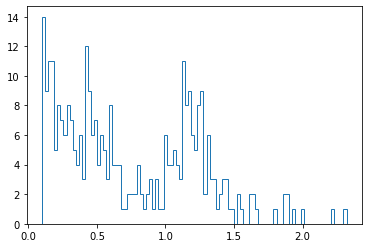

In [2]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 80)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

plt.hist(data, bins=100, histtype='step');

In [3]:
obs = zfit.Space('x', limits=bounds)

In [4]:
mean = zfit.Parameter("mean", 1.2, 0.5, 2.0)
sigma = zfit.Parameter("sigma", 0.1, 0.02, 0.2)
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 20., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [5]:
signal = zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [6]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_) 

In [7]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [8]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
print(minimum)

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


------------------------------------------------------------------
| FCN = -1431                   |     Ncalls=148 (148 total)     |
| EDM = 0.000403 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_1, Composed_autoparam_2] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f82a81d7f10>] constraints=[]> 
w

Text(0, 0.5, 'number of events')

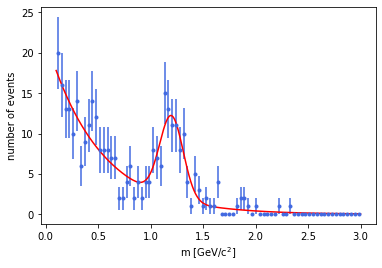

In [9]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Confidence interval

We want to compute the confidence interval of the mean of the Gaussian at 68% confidence level.

In [10]:
# instantation of the calculator
#calculator = FrequentistCalculator(nll, minimizer, ntoysnull=100)
calculator = FrequentistCalculator.from_yaml("toys/ci_freq_zfit_toys.yml", nll, minimizer, ntoysnull=2000)
calculator.bestfit = minimum #optionnal

In [11]:
# parameter of interest of the null hypothesis
poinull = POIarray(mean, np.linspace(1.15, 1.26, 50))

In [12]:
# instantation of the discovery test
ci = ConfidenceInterval(calculator, poinull)

In [13]:
ci.interval();


Confidence interval on mean:
	1.1808690201574854 < mean < 1.2157753628218937 at 68.0% C.L.


Text(0.5, 0, 'mean')

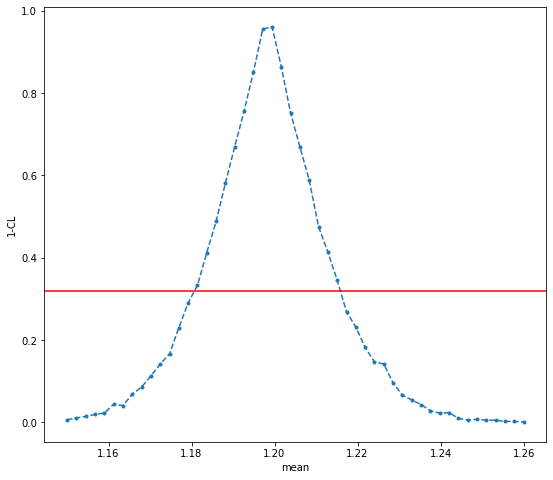

In [14]:
f = plt.figure(figsize=(9, 8))
one_minus_cl_plot(poinull.values, ci.pvalues())
plt.xlabel("mean")

In [15]:
calculator.to_yaml("toys/ci_freq_zfit_toys.yml")